In this project, I am going to visualize the Walkability Index of a suburb(Accra) using maps or other graphical representations to understand the spatial distribution of walkability within the suburb.

A secondary purpose of this notebook is to be an introduction to basic Python, the pandas data analytics library and matplotlib.

Importing libraries and technologies needed for the rest of the notebook.

In [1]:
#We don't use seaborn in this particular notebook, but it makes matplotlib charts look nicer.
import seaborn as sns 

import osmnx as ox

import pandas as pd
from pandas import Series,DataFrame

#To display the figures in the notebook itself.
%matplotlib inline

## Data Acquisition
Using the python OSMNX library, I obtain the necessary data from OpenStreetMap (OSM) for the suburb to analyze.

Once the network graph is downloaded, I visualize it using ox.plot_graph(). This will show you the walk network of the specified suburb

In [2]:
suburb_name = "Accra"

graph = ox.graph_from_place(suburb_name, network_type="walk")

#ox.plot_graph(graph, node_size=1)

## Data Preparation
Once you have the OSM data, you need to preprocess it to extract the relevant features

### Road Connectivity

In [14]:
import osmnx as ox
import networkx as nx

G = ox.graph_from_place(suburb_name, network_type='all')


In [20]:
total_length = sum([data['length'] for u, v, data in G.edges(data=True)])

intersection_nodes = [node for node, degree in G.degree() if degree > 2]

num_intersections = len(intersection_nodes)

print("Total length: {:,}m".format(total_length))
print("Number of intersections: {:,}".format(num_intersections))


Total length: 6,593,160.413000006m
Number of intersections: 24,079


### Population Density

In [17]:
import prep

population = 2660000
area = 225.7
# Print the population density of Accra
data_density = prep.calculate_population_density(population, area)

### Land use mix

In [21]:
# Download the OSM data for the suburb
suburb_gdf = ox.geocode_to_gdf(suburb_name)

# Retrieve land use tags for the suburb
land_use_tags = ox.geometries_from_place(suburb_name, tags={"landuse": True})

# Print the land use tags and their frequencies
land_use_counts = land_use_tags["landuse"].value_counts()
print(land_use_counts)

landuse
residential          322
grass                175
commercial            83
industrial            22
cemetery              11
farmland              10
construction          10
religious              7
military               4
dump                   4
forest                 4
government             3
recreation_ground      3
farmyard               2
landfill               2
garages                1
retail                 1
plant_nursery          1
churchyard             1
public_office          1
salt_pond              1
Name: count, dtype: int64


### Spatial Intersection
Overlay land use mix data with the suburb's boundaries to extract the relevant land use mix within the region. Useing spatial operations like intersection or overlay to identify the land use polygons that fall within the suburb.

In [8]:
from prep import create_land_use_polygons
import geopandas as gpd
from shapely.geometry import Polygon

# Create a DataFrame with land use data
land_use_data = gpd.GeoDataFrame({
    'land_use': ['residential', 'grass', 'commercial', 'industrial', 'cemetery', 'farmland', 'construction', 'religious', 'military', 'dump', 'forest', 'government', 'recreation_ground', 'farmyard', 'landfill', 'garages', 'retail', 'plant_nursery', 'churchyard', 'public_office', 'salt_pond'],
    'count': [322, 175, 83, 22, 11, 10, 10, 7, 4, 4, 4, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1]
})

# Create polygons from land use data (assuming they have geometry coordinates)
land_use_polygons = create_land_use_polygons(land_use_data)

# Create a new DataFrame with the land use polygons
land_use_polygons_df = gpd.GeoDataFrame(land_use_polygons, columns=['land_use', 'geometry'], geometry='geometry')


# Define the geographical coordinates of the suburb's boundary
north = 37.8  # Latitude of the northern edge
south = 37.7  # Latitude of the southern edge
east = 144.98  # Longitude of the eastern edge
west = 144.95  # Longitude of the western edge

# Convert land_use_polygons_df to a GeoDataFrame
land_use_gdf = gpd.GeoDataFrame(land_use_polygons_df, geometry='geometry', crs='EPSG:4326')

# Create a polygon representing the suburb boundary
boundary_coords = [(west, south), (east, south), (east, north), (west, north)]
suburb_boundary = gpd.GeoDataFrame({'geometry': [Polygon(boundary_coords)]}, geometry='geometry', crs='EPSG:4326')

print(isinstance(land_use_gdf, gpd.GeoDataFrame))
print(isinstance(suburb_boundary, gpd.GeoDataFrame))

# Perform the overlay operation
land_use_within_suburb = gpd.overlay(land_use_gdf, suburb_boundary, how='intersection')

True
True


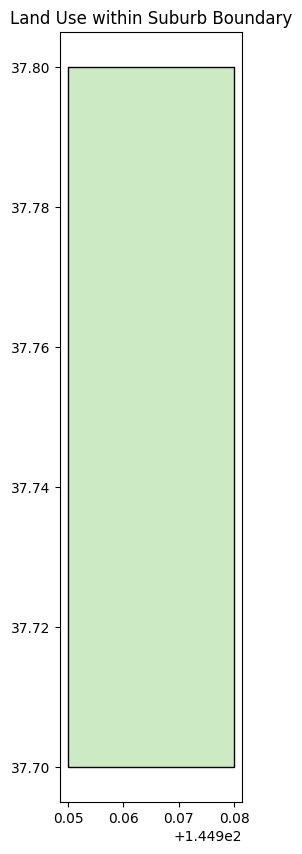

In [9]:
import matplotlib.pyplot as plt

# Plot the land use within the suburb boundary
fig, ax = plt.subplots(figsize=(10, 10))
land_use_within_suburb.plot(ax=ax, column='land_use', cmap='Set3')
suburb_boundary.plot(ax=ax, facecolor='none', edgecolor='black')
plt.title('Land Use within Suburb Boundary')
plt.show()

In [ ]:
import folium

# Create a folium map centered around the suburb boundary
m = folium.Map(location=[(north + south) / 2, (east + west) / 2], zoom_start=13)

# Convert land_use_within_suburb to GeoJSON format
land_use_geojson = land_use_within_suburb.__geo_interface__

# Add land_use_within_suburb to the map as a GeoJSON layer
folium.GeoJson(land_use_geojson).add_to(m)

# Add the suburb boundary to the map
folium.GeoJson(suburb_boundary.__geo_interface__, style_function=lambda x: {'color': 'black'}).add_to(m)

# Display the map
m